## PACS Domain Generalization with Vision Transformer (ViT)

## Setup & Imports

In [1]:

import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


c:\Users\Haseeb\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration & Seeds

In [49]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
SEED = 42
BATCH_SIZE = 24
NUM_EPOCHS = 5
NUM_CLASSES = 7
DATA_ROOT = "../../../pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
MODELS = {
    "base": "google/vit-base-patch16-224-in21k",
    "small": "WinKawaks/vit-small-patch16-224",
    "tiny": "WinKawaks/vit-tiny-patch16-224"
    }

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Device: cuda


## Dataset Wrapper Class

In [39]:

class PACSDataset:
    def __init__(self, data_root, domains, transform):
        self.data_root = data_root
        self.domains = domains
        self.transform = transform

    def get_dataloader(self, domain, train=True):
        dataset = datasets.ImageFolder(os.path.join(self.data_root, domain), transform=self.transform)
        
        indices = list(range(len(dataset)))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.targets[i] for i in indices], random_state=SEED)
        selected_idx = train_idx if train else val_idx
        
        subset = Subset(dataset, selected_idx)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=train)
        return loader


## Vision Transformer Wrapper Class

In [40]:

class ViTModel(nn.Module):
    def __init__(self, num_classes, model_size = "base"):
        super(ViTModel, self).__init__()
        self.model = ViTForImageClassification.from_pretrained(
            MODELS[model_size],
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

    def forward(self, x):
        return self.model(x).logits


## Trainer Class

In [41]:

class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model.to(DEVICE)
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, dataloader):
        self.model.train()
        total_loss = 0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate(self, dataloader):
        self.model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(inputs)
                preds = torch.argmax(outputs, dim=1)
                total_correct += (preds == labels).sum().item()
                total += labels.size(0)
        return total_correct / total


## Base ViT

### Leave-One-Domain-Out (LODO) Training

In [42]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_base = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_base = ViTModel(NUM_CLASSES, model_size="base")
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_base, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_base = trainer.train(train_loader)
        val_acc_base = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_base:.4f} | Val Acc: {val_acc_base:.4f}")

    # Test
    test_acc_base = trainer.evaluate(test_loader)
    results_base[test_domain] = test_acc_base
    print(f"✅ Test Accuracy on {test_domain}: {test_acc_base:.4f}")

\Testing on domain: art_painting


<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\3620165581.py:10: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Testing on domain: {test_domain}")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 265/265 [01:11<00:00,  3.71it/s]


Train Loss: 0.4947 | Val Acc: 0.9377
Epoch 2/5


100%|██████████| 265/265 [00:32<00:00,  8.15it/s]


Train Loss: 0.1220 | Val Acc: 0.9660
Epoch 3/5


100%|██████████| 265/265 [00:32<00:00,  8.21it/s]


Train Loss: 0.0642 | Val Acc: 0.9415
Epoch 4/5


100%|██████████| 265/265 [00:32<00:00,  8.18it/s]


Train Loss: 0.0503 | Val Acc: 0.9679
Epoch 5/5


100%|██████████| 265/265 [00:32<00:00,  8.13it/s]


Train Loss: 0.0335 | Val Acc: 0.9515
✅ Test Accuracy on art_painting: 0.9146
\Testing on domain: cartoon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:38<00:00,  6.66it/s]


Train Loss: 0.4876 | Val Acc: 0.9582
Epoch 2/5


100%|██████████| 255/255 [00:31<00:00,  8.11it/s]


Train Loss: 0.1142 | Val Acc: 0.9536
Epoch 3/5


100%|██████████| 255/255 [00:31<00:00,  8.12it/s]


Train Loss: 0.0582 | Val Acc: 0.9425
Epoch 4/5


100%|██████████| 255/255 [00:31<00:00,  8.10it/s]


Train Loss: 0.0442 | Val Acc: 0.9503
Epoch 5/5


100%|██████████| 255/255 [00:31<00:00,  8.13it/s]


Train Loss: 0.0659 | Val Acc: 0.9582
✅ Test Accuracy on cartoon: 0.7804
\Testing on domain: photo


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:34<00:00,  8.13it/s]


Train Loss: 0.5223 | Val Acc: 0.9171
Epoch 2/5


100%|██████████| 278/278 [00:34<00:00,  8.12it/s]


Train Loss: 0.1331 | Val Acc: 0.9520
Epoch 3/5


100%|██████████| 278/278 [00:34<00:00,  8.12it/s]


Train Loss: 0.0721 | Val Acc: 0.9285
Epoch 4/5


100%|██████████| 278/278 [00:34<00:00,  8.13it/s]


Train Loss: 0.0337 | Val Acc: 0.9495
Epoch 5/5


100%|██████████| 278/278 [00:33<00:00,  8.21it/s]


Train Loss: 0.0455 | Val Acc: 0.9604
✅ Test Accuracy on photo: 0.9820
\Testing on domain: sketch


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:25<00:00,  8.11it/s]


Train Loss: 0.4711 | Val Acc: 0.9456
Epoch 2/5


100%|██████████| 203/203 [00:24<00:00,  8.15it/s]


Train Loss: 0.0916 | Val Acc: 0.9703
Epoch 3/5


100%|██████████| 203/203 [00:25<00:00,  8.11it/s]


Train Loss: 0.0353 | Val Acc: 0.9777
Epoch 4/5


100%|██████████| 203/203 [00:25<00:00,  8.12it/s]


Train Loss: 0.0180 | Val Acc: 0.9530
Epoch 5/5


100%|██████████| 203/203 [00:24<00:00,  8.12it/s]


Train Loss: 0.0709 | Val Acc: 0.9703
✅ Test Accuracy on sketch: 0.6552


### Baseline

In [43]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_base = ViTModel(NUM_CLASSES, model_size="base")
baseline_optimizer = optim.Adam(baseline_model_base.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_base, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_base = baseline_trainer.train(full_train_loader)
    baseline_val_acc_base = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_base:.4f} | Baseline Acc: {baseline_val_acc_base:.4f}")

# Test baseline
baseline_test_acc_base = baseline_trainer.evaluate(full_test_loader)
results_base['baseline_all_domains'] = baseline_test_acc_base
print(f"Baseline Test Accuracy: {baseline_test_acc_base:.4f}")


\Baseline: training on all domains and testing on mixed domains


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\3090319873.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\Baseline: training on all domains and testing on mixed domains")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:41<00:00,  8.02it/s]


Baseline Loss: 0.4803 | Baseline Acc: 0.9485
Baseline Epoch 2/5


100%|██████████| 333/333 [00:40<00:00,  8.18it/s]


Baseline Loss: 0.1050 | Baseline Acc: 0.9570
Baseline Epoch 3/5


100%|██████████| 333/333 [00:40<00:00,  8.21it/s]


Baseline Loss: 0.0697 | Baseline Acc: 0.9265
Baseline Epoch 4/5


100%|██████████| 333/333 [00:40<00:00,  8.17it/s]


Baseline Loss: 0.0589 | Baseline Acc: 0.9435
Baseline Epoch 5/5


100%|██████████| 333/333 [00:40<00:00,  8.16it/s]


Baseline Loss: 0.0249 | Baseline Acc: 0.9410
Baseline Test Accuracy: 0.9410


### Visual Comparison

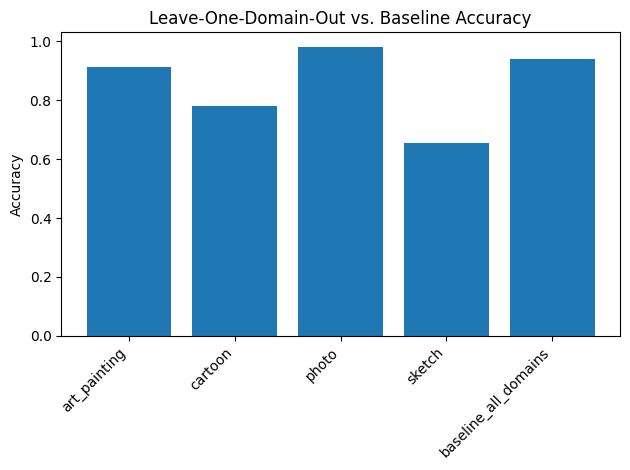

In [44]:
domains = list(results_base.keys())
accuracies = [results_base[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy')
plt.tight_layout()
plt.show()

### Final Results

In [45]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_base.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_base.values()) / len(results_base)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.9146
cartoon: 0.7804
photo: 0.9820
sketch: 0.6552
baseline_all_domains: 0.9410

Average Accuracy: 0.8546


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\165815634.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## Small ViT

### Leave-One-Domain-Out (LODO) Training

In [50]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_small = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_small = ViTModel(NUM_CLASSES, model_size="small")
    optimizer = optim.Adam(model_small.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_small, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_small = trainer.train(train_loader)
        val_acc_small = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_small:.4f} | Val Acc: {val_acc_small:.4f}")

    # Test
    test_acc_small = trainer.evaluate(test_loader)
    results_small[test_domain] = test_acc_small
    print(f"✅ Test Accuracy on {test_domain}: {test_acc_small:.4f}")

<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\3618803983.py:10: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Testing on domain: {test_domain}")


\Testing on domain: art_painting


c:\Users\Haseeb\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Haseeb\.cache\huggingface\hub\models--WinKawaks--vit-small-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of ViTForImageClassification were not initialized from the model ch

Epoch 1/5


100%|██████████| 265/265 [00:17<00:00, 15.04it/s]


Train Loss: 0.2954 | Val Acc: 0.9440
Epoch 2/5


100%|██████████| 265/265 [00:17<00:00, 15.15it/s]


Train Loss: 0.0672 | Val Acc: 0.9346
Epoch 3/5


100%|██████████| 265/265 [00:17<00:00, 15.12it/s]


Train Loss: 0.0496 | Val Acc: 0.9402
Epoch 4/5


100%|██████████| 265/265 [00:17<00:00, 15.16it/s]


Train Loss: 0.0589 | Val Acc: 0.9648
Epoch 5/5


100%|██████████| 265/265 [00:17<00:00, 15.20it/s]


Train Loss: 0.0328 | Val Acc: 0.9534
✅ Test Accuracy on art_painting: 0.8268
\Testing on domain: cartoon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:16<00:00, 15.14it/s]


Train Loss: 0.2974 | Val Acc: 0.9451
Epoch 2/5


100%|██████████| 255/255 [00:16<00:00, 15.09it/s]


Train Loss: 0.0865 | Val Acc: 0.9444
Epoch 3/5


100%|██████████| 255/255 [00:16<00:00, 15.22it/s]


Train Loss: 0.0615 | Val Acc: 0.9301
Epoch 4/5


100%|██████████| 255/255 [00:16<00:00, 15.11it/s]


Train Loss: 0.0414 | Val Acc: 0.9399
Epoch 5/5


100%|██████████| 255/255 [00:17<00:00, 15.00it/s]


Train Loss: 0.0545 | Val Acc: 0.9562
✅ Test Accuracy on cartoon: 0.8017
\Testing on domain: photo


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:18<00:00, 15.14it/s]


Train Loss: 0.3208 | Val Acc: 0.9544
Epoch 2/5


100%|██████████| 278/278 [00:18<00:00, 15.10it/s]


Train Loss: 0.0682 | Val Acc: 0.9514
Epoch 3/5


100%|██████████| 278/278 [00:18<00:00, 15.21it/s]


Train Loss: 0.0581 | Val Acc: 0.9574
Epoch 4/5


100%|██████████| 278/278 [00:18<00:00, 15.08it/s]


Train Loss: 0.0564 | Val Acc: 0.9369
Epoch 5/5


100%|██████████| 278/278 [00:18<00:00, 15.17it/s]


Train Loss: 0.0513 | Val Acc: 0.9447
✅ Test Accuracy on photo: 0.9790
\Testing on domain: sketch


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:13<00:00, 14.91it/s]


Train Loss: 0.2124 | Val Acc: 0.9563
Epoch 2/5


100%|██████████| 203/203 [00:13<00:00, 15.10it/s]


Train Loss: 0.0484 | Val Acc: 0.9547
Epoch 3/5


100%|██████████| 203/203 [00:13<00:00, 14.99it/s]


Train Loss: 0.0269 | Val Acc: 0.9678
Epoch 4/5


100%|██████████| 203/203 [00:13<00:00, 15.02it/s]


Train Loss: 0.0265 | Val Acc: 0.9662
Epoch 5/5


100%|██████████| 203/203 [00:13<00:00, 15.00it/s]


Train Loss: 0.0606 | Val Acc: 0.8359
✅ Test Accuracy on sketch: 0.5293


### Baseline

In [51]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_small = ViTModel(NUM_CLASSES)
baseline_optimizer = optim.Adam(baseline_model_small.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_small, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_small = baseline_trainer.train(full_train_loader)
    baseline_val_acc_small = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_small:.4f} | Baseline Acc: {baseline_val_acc_small:.4f}")

# Test baseline
baseline_test_acc_small = baseline_trainer.evaluate(full_test_loader)
results_small['baseline_all_domains'] = baseline_test_acc_small
print(f"Baseline Test Accuracy: {baseline_test_acc_small:.4f}")


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\4265002456.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\Baseline: training on all domains and testing on mixed domains")


\Baseline: training on all domains and testing on mixed domains


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:41<00:00,  8.04it/s]


Baseline Loss: 0.4549 | Baseline Acc: 0.9570
Baseline Epoch 2/5


100%|██████████| 333/333 [00:41<00:00,  8.07it/s]


Baseline Loss: 0.0932 | Baseline Acc: 0.9355
Baseline Epoch 3/5


100%|██████████| 333/333 [00:41<00:00,  8.05it/s]


Baseline Loss: 0.0521 | Baseline Acc: 0.9630
Baseline Epoch 4/5


100%|██████████| 333/333 [00:41<00:00,  8.05it/s]


Baseline Loss: 0.0562 | Baseline Acc: 0.9590
Baseline Epoch 5/5


100%|██████████| 333/333 [00:41<00:00,  8.05it/s]


Baseline Loss: 0.0510 | Baseline Acc: 0.9565
Baseline Test Accuracy: 0.9565


### Visual Comparison

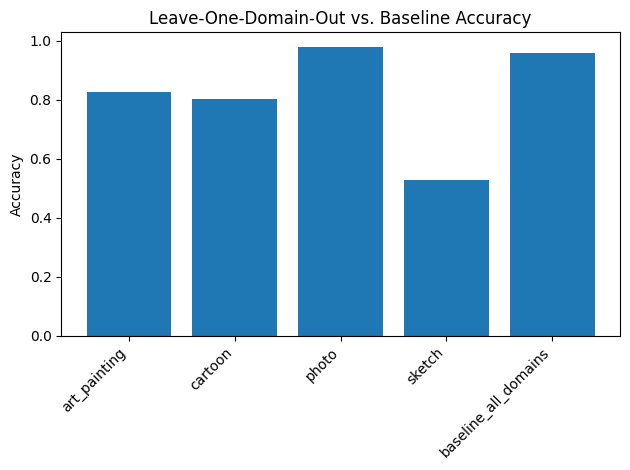

In [52]:
domains = list(results_small.keys())
accuracies = [results_small[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy')
plt.tight_layout()
plt.show()

### Final Results

In [53]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_small.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_small.values()) / len(results_small)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.8268
cartoon: 0.8017
photo: 0.9790
sketch: 0.5293
baseline_all_domains: 0.9565

Average Accuracy: 0.8187


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\3963232904.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## Tiny ViT

### Leave-One-Domain-Out (LODO) Training

In [54]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_tiny = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_tiny = ViTModel(NUM_CLASSES, model_size="tiny")
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_tiny, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_tiny = trainer.train(train_loader)
        val_acc_tiny = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_tiny:.4f} | Val Acc: {val_acc_tiny:.4f}")

    # Test
    test_acc_tiny = trainer.evaluate(test_loader)
    results_tiny[test_domain] = test_acc_tiny
    print(f"✅ Test Accuracy on {test_domain}: {test_acc_tiny:.4f}")

\Testing on domain: art_painting


<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\2473320083.py:10: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Testing on domain: {test_domain}")
c:\Users\Haseeb\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Haseeb\.cache\huggingface\hub\models--WinKawaks--vit-tiny-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administ

Epoch 1/5


100%|██████████| 265/265 [00:13<00:00, 20.25it/s]


Train Loss: 2.2721 | Val Acc: 0.1674
Epoch 2/5


100%|██████████| 265/265 [00:12<00:00, 20.65it/s]


Train Loss: 2.2724 | Val Acc: 0.1674
Epoch 3/5


100%|██████████| 265/265 [00:12<00:00, 20.81it/s]


Train Loss: 2.2722 | Val Acc: 0.1674
Epoch 4/5


100%|██████████| 265/265 [00:12<00:00, 20.74it/s]


Train Loss: 2.2723 | Val Acc: 0.1674
Epoch 5/5


100%|██████████| 265/265 [00:12<00:00, 20.88it/s]


Train Loss: 2.2723 | Val Acc: 0.1674
✅ Test Accuracy on art_painting: 0.1220
\Testing on domain: cartoon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:12<00:00, 20.94it/s]


Train Loss: 2.2549 | Val Acc: 0.1157
Epoch 2/5


100%|██████████| 255/255 [00:12<00:00, 21.00it/s]


Train Loss: 2.2549 | Val Acc: 0.1157
Epoch 3/5


100%|██████████| 255/255 [00:12<00:00, 21.14it/s]


Train Loss: 2.2549 | Val Acc: 0.1157
Epoch 4/5


100%|██████████| 255/255 [00:11<00:00, 21.28it/s]


Train Loss: 2.2549 | Val Acc: 0.1157
Epoch 5/5


100%|██████████| 255/255 [00:12<00:00, 21.22it/s]


Train Loss: 2.2548 | Val Acc: 0.1157
✅ Test Accuracy on cartoon: 0.1812
\Testing on domain: photo


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:13<00:00, 20.97it/s]


Train Loss: 2.4022 | Val Acc: 0.0871
Epoch 2/5


100%|██████████| 278/278 [00:13<00:00, 21.19it/s]


Train Loss: 2.4026 | Val Acc: 0.0871
Epoch 3/5


100%|██████████| 278/278 [00:13<00:00, 21.25it/s]


Train Loss: 2.4014 | Val Acc: 0.0871
Epoch 4/5


100%|██████████| 278/278 [00:13<00:00, 21.12it/s]


Train Loss: 2.4015 | Val Acc: 0.0871
Epoch 5/5


100%|██████████| 278/278 [00:13<00:00, 21.23it/s]


Train Loss: 2.4024 | Val Acc: 0.0871
✅ Test Accuracy on photo: 0.1557
\Testing on domain: sketch


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:09<00:00, 20.68it/s]


Train Loss: 2.6966 | Val Acc: 0.0701
Epoch 2/5


100%|██████████| 203/203 [00:09<00:00, 20.70it/s]


Train Loss: 2.6953 | Val Acc: 0.0701
Epoch 3/5


100%|██████████| 203/203 [00:09<00:00, 20.75it/s]


Train Loss: 2.6927 | Val Acc: 0.0701
Epoch 4/5


100%|██████████| 203/203 [00:09<00:00, 20.61it/s]


Train Loss: 2.6886 | Val Acc: 0.0701
Epoch 5/5


100%|██████████| 203/203 [00:09<00:00, 20.67it/s]


Train Loss: 2.6941 | Val Acc: 0.0701
✅ Test Accuracy on sketch: 0.2214


### Baseline

In [55]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_tiny = ViTModel(NUM_CLASSES)
baseline_optimizer = optim.Adam(baseline_model_tiny.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_tiny, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_tiny = baseline_trainer.train(full_train_loader)
    baseline_val_acc_tiny = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_tiny:.4f} | Baseline Acc: {baseline_val_acc_tiny:.4f}")

# Test baseline
baseline_test_acc_tiny = baseline_trainer.evaluate(full_test_loader)
results_tiny['baseline_all_domains'] = baseline_test_acc_tiny
print(f"Baseline Test Accuracy: {baseline_test_acc_tiny:.4f}")


\Baseline: training on all domains and testing on mixed domains


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\3161607150.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\Baseline: training on all domains and testing on mixed domains")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:40<00:00,  8.17it/s]


Baseline Loss: 0.4520 | Baseline Acc: 0.9435
Baseline Epoch 2/5


100%|██████████| 333/333 [00:40<00:00,  8.20it/s]


Baseline Loss: 0.1008 | Baseline Acc: 0.9605
Baseline Epoch 3/5


100%|██████████| 333/333 [00:40<00:00,  8.17it/s]


Baseline Loss: 0.0498 | Baseline Acc: 0.9360
Baseline Epoch 4/5


100%|██████████| 333/333 [00:41<00:00,  8.09it/s]


Baseline Loss: 0.0435 | Baseline Acc: 0.9490
Baseline Epoch 5/5


100%|██████████| 333/333 [00:41<00:00,  8.09it/s]


Baseline Loss: 0.0564 | Baseline Acc: 0.9635
Baseline Test Accuracy: 0.9635


### Visual Comparison

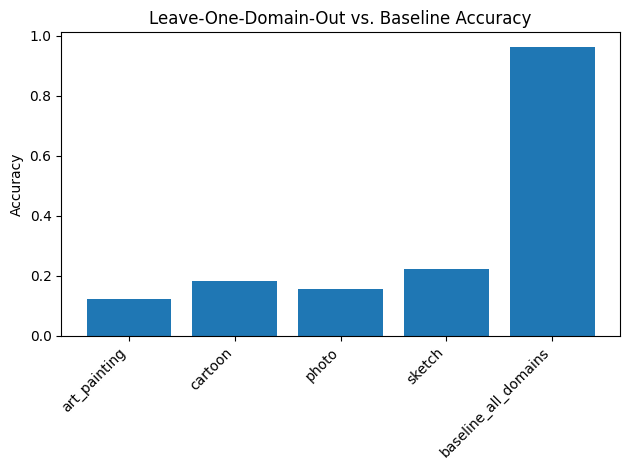

In [56]:
domains = list(results_tiny.keys())
accuracies = [results_tiny[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy')
plt.tight_layout()
plt.show()

### Final Results

In [57]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_tiny.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_tiny.values()) / len(results_tiny)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.1220
cartoon: 0.1812
photo: 0.1557
sketch: 0.2214
baseline_all_domains: 0.9635

Average Accuracy: 0.3287


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_38960\1740940439.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## Model Comparison

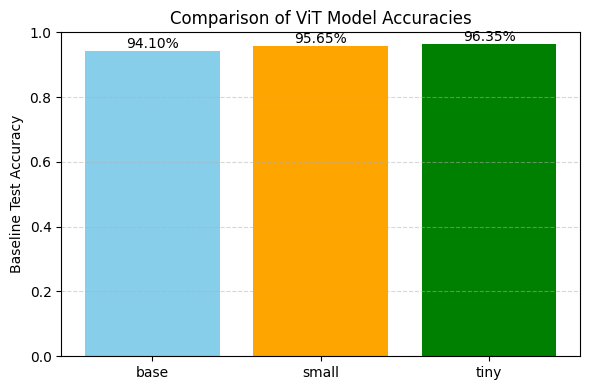

In [60]:
accuracies = [results_base["baseline_all_domains"], results_small["baseline_all_domains"], results_tiny["baseline_all_domains"]]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(MODELS.keys(), accuracies, color=["skyblue", "orange", "green"])
plt.ylim(0, 1)
plt.ylabel("Baseline Test Accuracy")
plt.title("Comparison of ViT Model Accuracies")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

plt.tight_layout()
plt.show()